# Owners & collaborators

In [1]:
from prep_n_load import *

4822 parcels loaded.


## Number of owners, min/max ownerships

In [2]:
from collections import Counter
parcels_per_owner = Counter(parcels.owner)
counts = list(parcels_per_owner.values())
print("{} owners total".format(len(parcels_per_owner)))
print("Ownerhips: {} min, {} max".format(sorted(counts)[0], sorted(counts)[-1]))


1216 owners total
Ownerhips: 1 min, 168 max


## Owner leaderboard

In [3]:
show_leaderboard(parcels_per_owner, "parcels")

* Top spot is The Vault by $WHALE.

## Histogram of ownerships

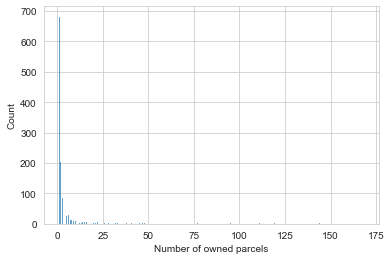

In [4]:
ax = sns.histplot(data=counts)
ax.set(xlabel="Number of owned parcels")
plt.show()


* Obviously most owners own 1 parcel. Many 2 or 3. Curve flattens quickly afterwards.

### Zooming in: histogram & cumulative distribution

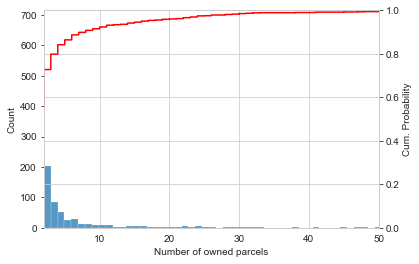

In [5]:
fig, ax = plt.subplots()
sns.histplot(data=counts, ax=ax, bins=max(counts) + 1)
ax.set(xlabel="Number of owned parcels")
ax.set(xlim=(2, 50))
ax.grid(False, axis="y")
ax2 = ax.twinx()
sns.ecdfplot(data=counts, ax=ax2, color="red")
ax2.set(xlim=(2, 50))
ax2.set(ylabel="Cum. Probability")
plt.locator_params(axis="x", integer=True, tight=True)
plt.show()


* Owning > ~5 parcels brings you to the top decile of owners.

## Distribution of ownership

How well distributed is parcel ownership? I.e., is a large number of parcels in the hands of only a few?

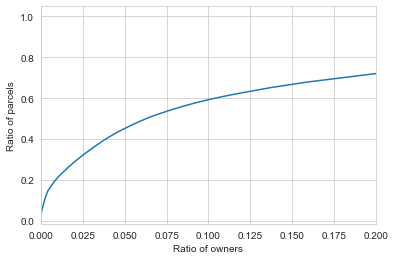

In [6]:
# What ratio of parcels does each owner own:
parcel_ratios = [c/parcels.shape[0] for o, c in sorted(parcels_per_owner.items(), key=lambda x: x[1], reverse=True)]
# Cumulated:
cumulated_parcel_ratios = [ sum(parcel_ratios[:i+1]) for i, r in enumerate(parcel_ratios)]
# Cumulated owner ratios:
cumulated_owner_ratios = [x/len(parcel_ratios) for x in range(len(parcel_ratios))]
# Plot:
ax = sns.lineplot(x=cumulated_owner_ratios, y=cumulated_parcel_ratios)
ax.set(xlabel="Ratio of owners")
ax.set(ylabel="Ratio of parcels")
ax.set(xlim=(0, 0.2))
plt.show()

* 10% of the owners own 60% of all parcels.
* ~6% of the owners own half of all the parcels.

## Collaborators

In [7]:
collaborators = Counter([cleanc for p in parcels.contributors for c in (p or []) for cleanc in c.strip().split(" ") if cleanc != ""])
collaborator_counts = list(collaborators.values())
print("{} collaborators total".format(len(collaborators)))
print("Collaborations: {} min, {} max".format(sorted(collaborator_counts)[0], sorted(collaborator_counts)[-1]))


1330 collaborators total
Collaborations: 1 min, 68 max


## Collaborators leaderboard

In [8]:
show_leaderboard(collaborators, "collaborations")

## Owner-collaborators

How many owners are also collaborators?

In [9]:
len(set(parcels_per_owner.keys()) & set(collaborators.keys()))

224